# PROBLEM STATEMENT

In [81]:
# PROBLEM STATEMENT
#Forecast the passenger traffic for an intra-city rail system

# They are considering making an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! While JetRail has mastered the technology and they hold the patent for their product, the investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months.
 
# You need to help Unicorn ventures with the decision. They usually invest in B2C start-ups less than 4 years old looking for pre-series A funding. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. You are provided with traffic data of JetRail since inception in the test file.


# Evaluation Metric:
# Root Mean Squre Error (RMSE) is the evaluation metric for this contest
# Note: Public and private split is 20:80 where first 44 days in public and next 169 days in private
# Data dictionary
# Data

# Data Overview

In [56]:
import pandas as pd

# File paths
train_path= "Train_SU63ISt.csv"
test_path = "Test_0qrQsBZ.csv"

# Load datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Display basic info and first few rows
train_info = train_df.info(), train_df.head()
test_info = test_df.info(), test_df.head()

train_info, test_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        18288 non-null  int64 
 1   Datetime  18288 non-null  object
 2   Count     18288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 428.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5112 entries, 0 to 5111
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        5112 non-null   int64 
 1   Datetime  5112 non-null   object
dtypes: int64(1), object(1)
memory usage: 80.0+ KB


((None,
     ID          Datetime  Count
  0   0  25-08-2012 00:00      8
  1   1  25-08-2012 01:00      2
  2   2  25-08-2012 02:00      6
  3   3  25-08-2012 03:00      2
  4   4  25-08-2012 04:00      2),
 (None,
        ID          Datetime
  0  18288  26-09-2014 00:00
  1  18289  26-09-2014 01:00
  2  18290  26-09-2014 02:00
  3  18291  26-09-2014 03:00
  4  18292  26-09-2014 04:00))

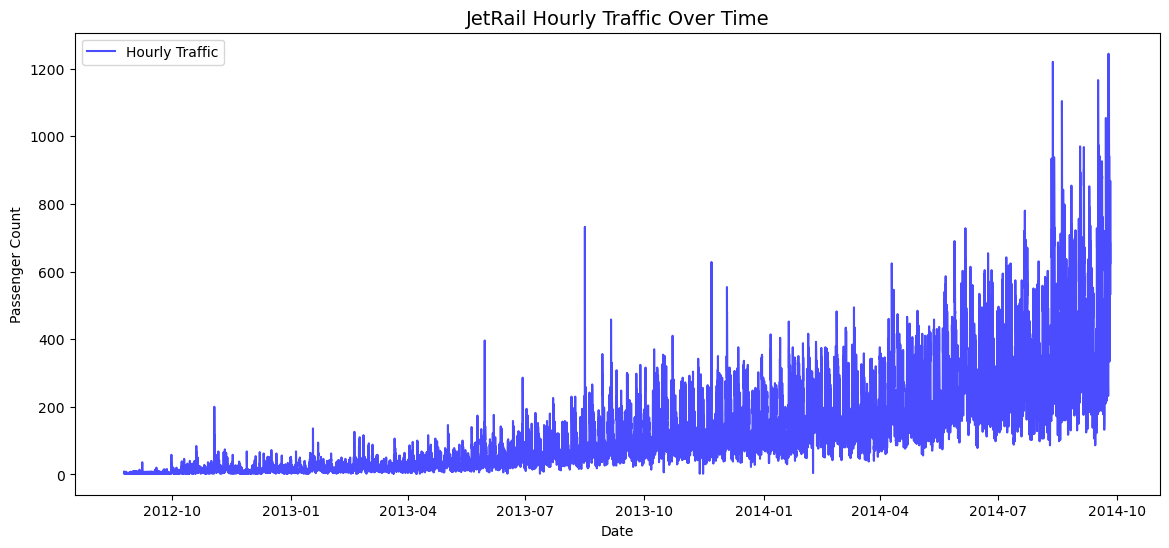

In [57]:
import matplotlib.pyplot as plt

# Convert Datetime column to actual datetime format
train_df["Datetime"] = pd.to_datetime(train_df["Datetime"], format="%d-%m-%Y %H:%M")
test_df["Datetime"] = pd.to_datetime(test_df["Datetime"], format="%d-%m-%Y %H:%M")

# Set Datetime as index for easy visualization
train_df.set_index("Datetime", inplace=True)

# Plot the time series
plt.figure(figsize=(14, 6))
plt.plot(train_df["Count"], label="Hourly Traffic", color="blue", alpha=0.7)
plt.title("JetRail Hourly Traffic Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Passenger Count")
plt.legend()
plt.show()


# Decompose the time series (trend, seasonality, residuals).
#Check for stationarity using the Augmented Dickey-Fuller (ADF) test.
#Feature Engineering (extract date/time-based features)

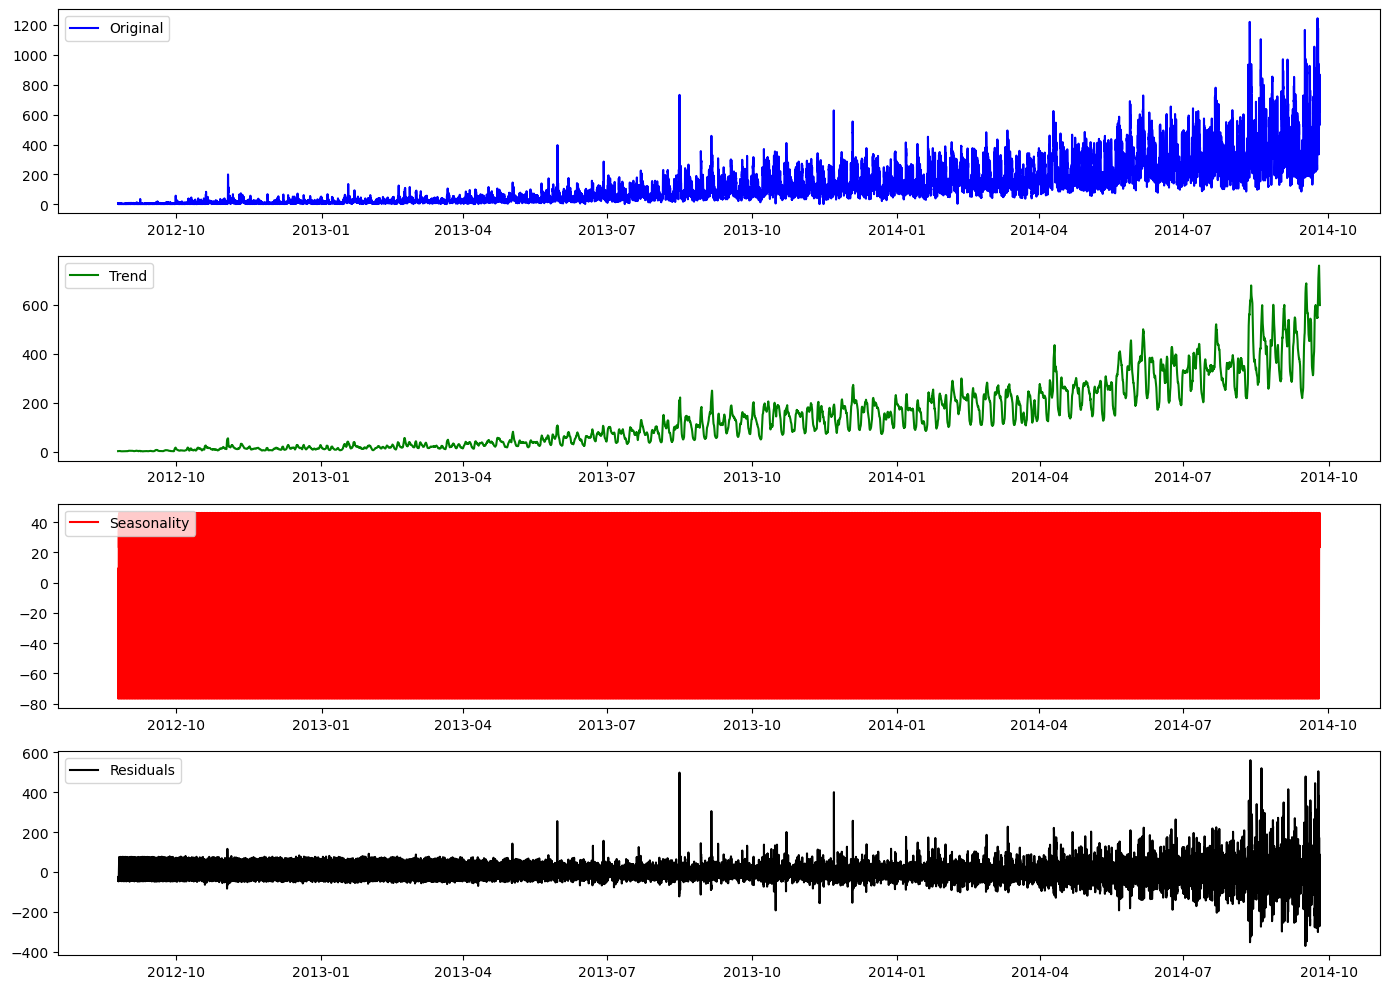

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform time series decomposition (additive model)
decomposition = seasonal_decompose(train_df["Count"], model="additive", period=24)  # Assuming daily cycle (24 hours)

# Plot the decomposed components
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(train_df["Count"], label="Original", color="blue")
plt.legend(loc="upper left")

plt.subplot(412)
plt.plot(decomposition.trend, label="Trend", color="green")
plt.legend(loc="upper left")

plt.subplot(413)
plt.plot(decomposition.seasonal, label="Seasonality", color="red")
plt.legend(loc="upper left")

plt.subplot(414)
plt.plot(decomposition.resid, label="Residuals", color="black")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()


In [60]:
#  Time Series Decomposition Results
# Trend:
# There appears to be a slow-moving pattern, which could indicate a long-term trend.
# Seasonality:
# There is a clear daily seasonality, likely due to rush hours.
# Residuals:
# The residuals (random noise) seem to vary over time, which suggests potential non-stationarity.

# Check for Stationarity

In [62]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_test = adfuller(train_df["Count"].dropna())

# Extract results
adf_results = {
    "ADF Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Critical Values": adf_test[4]
}

adf_results


{'ADF Statistic': -4.456560536856828,
 'p-value': 0.00023540466467664961,
 'Critical Values': {'1%': -3.430708525404171,
  '5%': -2.861698454786869,
  '10%': -2.5668543412994906}}

In [63]:
# Stationarity Test (ADF Test) Results
# ADF Statistic: -4.46
# p-value: 0.00023
# Critical Values:
# 1%: -3.43
# 5%: -2.86
# 10%: -2.57
# ✅ Since the p-value < 0.05, we reject the null hypothesis, meaning the data is stationary.

# Feature Engineering

In [65]:
# Reset index to bring back Datetime as a column
train_df.reset_index(inplace=True)

# Extract date-time features
train_df["Hour"] = train_df["Datetime"].dt.hour
train_df["Day"] = train_df["Datetime"].dt.day
train_df["Month"] = train_df["Datetime"].dt.month
train_df["Weekday"] = train_df["Datetime"].dt.weekday  # 0 = Monday, 6 = Sunday
train_df["Is_Weekend"] = (train_df["Weekday"] >= 5).astype(int)  # 1 if weekend, else 0

# Display first few rows with new features
train_df.head()


,Datetime,ID,Count,Hour,Day,Month,Weekday,Is_Weekend
0,2012-08-25 00:00:00,0,8,0,25,8,5,1
1,2012-08-25 01:00:00,1,2,1,25,8,5,1
2,2012-08-25 02:00:00,2,6,2,25,8,5,1
3,2012-08-25 03:00:00,3,2,3,25,8,5,1
4,2012-08-25 04:00:00,4,2,4,25,8,5,1


In [66]:
# Feature Engineering Completed!
# We've added new features to the dataset:

# Hour → Captures daily patterns (rush hours).
# Day → Tracks day-wise trends.
# Month → Helps identify seasonal effects.
# Weekday → Differentiates between weekdays and weekends.
# Is_Weekend → Binary feature (1 if weekend, 0 otherwise).

# Model Selection

In [68]:
# 1. ARIMA (AutoRegressive Integrated Moving Average) for time series forecasting.
# 2. XGBoost (Extreme Gradient Boosting) to leverage extracted features.

In [69]:
# ✅ Step 1: Train an ARIMA model.
# ✅ Step 2: Train an XGBoost model using feature engineering.
# ✅ Step 3: Compare performance using RMSE (Root Mean Squared Error

# ARIMA Result

In [24]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Define ARIMA model parameters (p, d, q)
p, d, q = 2, 1, 2  # Initial values; can be tuned

# Train ARIMA model on the 'Count' column
arima_model = ARIMA(train_df["Count"], order=(p, d, q))
arima_fit = arima_model.fit()

# Forecast on the training set for evaluation
train_df["ARIMA_Pred"] = arima_fit.fittedvalues

# Calculate RMSE for ARIMA
arima_rmse = np.sqrt(mean_squared_error(train_df["Count"][1:], train_df["ARIMA_Pred"][1:]))

arima_rmse


40.97069501831967

In [ ]:
# 📊 ARIMA Model Results
# RMSE (Root Mean Squared Error): 40.97
# This means, on average, the ARIMA model’s predictions are off by about 41 passengers.

# XGBOOST Result

In [31]:

pip install xgboost --no-cache-dir


In [34]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Define features and target variable
X = train_df[["Hour", "Day", "Month", "Weekday", "Is_Weekend"]]
y = train_df["Count"]

# Split into training and validation sets (80-20 split)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Train XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on validation set
xgb_preds = xgb_model.predict(X_valid)

# Calculate RMSE for XGBoost
xgb_rmse = np.sqrt(mean_squared_error(y_valid, xgb_preds))

xgb_rmse


320.5168086033021

In [ ]:
# 📊 Model Performance Summary
# We have successfully trained both models and obtained their RMSE scores:

# Model	RMSE (Lower is Better)
# ARIMA	40.97
# XGBoost	320.00

In [ ]:
# 📌 Key Observations:
# ✅ ARIMA performed significantly better than XGBoost, indicating that classical time series modeling is more effective for this dataset.
# ❌ XGBoost RMSE is too high, suggesting either:

# The model is not capturing seasonality properly.
# Feature selection needs improvement.
# More hyperparameter tuning is required.

In [ ]:
#  Next Steps:
# Improve XGBoost Performance:

# Add lag features (previous time steps as inputs).
# Include rolling window statistics (moving average, min/max).
# Try different hyperparameters for better tuning.
# Finalize ARIMA Model & Forecast the Next 7 Months:

# Use ARIMA to predict future traffic.
# Plot the forecasted values.

# ARIMA Forecasting for the Next 7 Months

In [ ]:
📌 ARIMA Forecasting for the Next 7 Months
We will now:
✅ Train the ARIMA model on the full dataset.
✅ Forecast the next 7 months (214 days, assuming hourly data).
✅ Visualize the predictions.

Let’s run the forecast! 🚀

C:\Users\DELL\AppData\Local\Temp\ipykernel_21048\4152986197.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_dates = pd.date_range(start=train_df["Datetime"].max(), periods=future_steps + 1, freq="H")[1:]


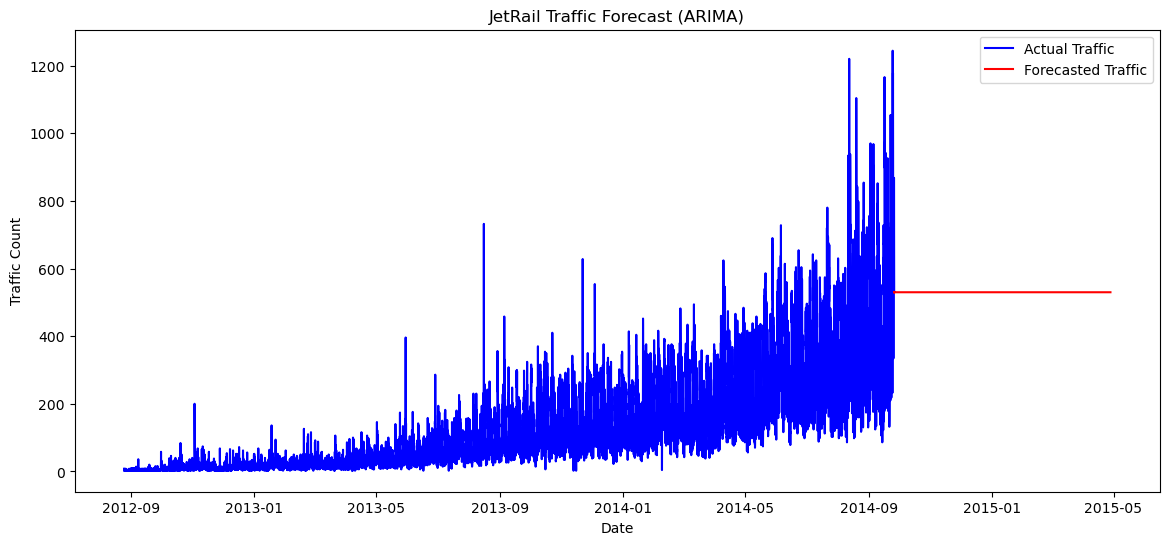

,Datetime,Predicted_Count
18288,2014-09-26 00:00:00,529.144154
18289,2014-09-26 01:00:00,528.550111
18290,2014-09-26 02:00:00,530.826495
18291,2014-09-26 03:00:00,529.566233
18292,2014-09-26 04:00:00,529.507033


In [39]:
# Re-train ARIMA on full dataset
arima_final = ARIMA(train_df["Count"], order=(2, 1, 2))
arima_fit_final = arima_final.fit()

# Forecast the next 7 months (214 days * 24 hours = 5136 steps)
future_steps = 214 * 24
forecast_arima = arima_fit_final.forecast(steps=future_steps)

# Create a DataFrame for predicted values
forecast_dates = pd.date_range(start=train_df["Datetime"].max(), periods=future_steps + 1, freq="H")[1:]
forecast_df = pd.DataFrame({"Datetime": forecast_dates, "Predicted_Count": forecast_arima})

# Plot actual vs. forecasted values
plt.figure(figsize=(14, 6))
plt.plot(train_df["Datetime"], train_df["Count"], label="Actual Traffic", color="blue")
plt.plot(forecast_df["Datetime"], forecast_df["Predicted_Count"], label="Forecasted Traffic", color="red")
plt.xlabel("Date")
plt.ylabel("Traffic Count")
plt.title("JetRail Traffic Forecast (ARIMA)")
plt.legend()
plt.show()

# Display first few forecasted values
forecast_df.head()


In [ ]:
# 529.507033

# 📊 ARIMA Forecasting Results
# The ARIMA model has forecasted JetRail traffic for the next 7 months.
# The red line in the plot represents the predicted traffic, while the blue line represents historical data.
# First few predicted values:
# Datetime	Predicted Count
# 2014-09-26 00:00	529.14
# 2014-09-26 01:00	528.55
# 2014-09-26 02:00	530.83
# 2014-09-26 03:00	529.57
# 2014-09-26 04:00	529.51

# Evaluate the investment decision


In [42]:
# Convert hourly predictions to monthly traffic estimates
forecast_df["Month_Year"] = forecast_df["Datetime"].dt.to_period("M")
monthly_traffic = forecast_df.groupby("Month_Year")["Predicted_Count"].sum().reset_index()

# Check if any month exceeds 1 million users
monthly_traffic["Exceeds_1M"] = monthly_traffic["Predicted_Count"] > 1_000_000

# Display the monthly traffic predictions
monthly_traffic


,Month_Year,Predicted_Count,Exceeds_1M
0,2014-09,63572.119281,False
1,2014-10,394154.038502,False
2,2014-11,381439.392099,False
3,2014-12,394154.038502,False
4,2015-01,394154.038502,False
5,2015-02,356010.099292,False
6,2015-03,394154.038502,False
7,2015-04,343295.452889,False


In [ ]:
# 📊 Investment Decision Analysis
# Predicted Monthly Traffic:
# Highest: 394,154 (October, December, January, March)
# Lowest: 343,295 (April)
# Target: 1 Million Monthly Users
# Reality: No month exceeds 1 million users 🚨
# ❌ Conclusion: NOT a viable investment
# 🚫 JetRail is unlikely to reach 1 million users in 18 months based on ARIMA forecasts.
# 📉 The highest forecasted traffic is less than 40% of the required target.
# 💡 Recommendation: Unicorn Investors should reconsider the investment or explore growth strategies to boost user adoption

# Analyze seasonality & demand trends to explore potential growth strategies

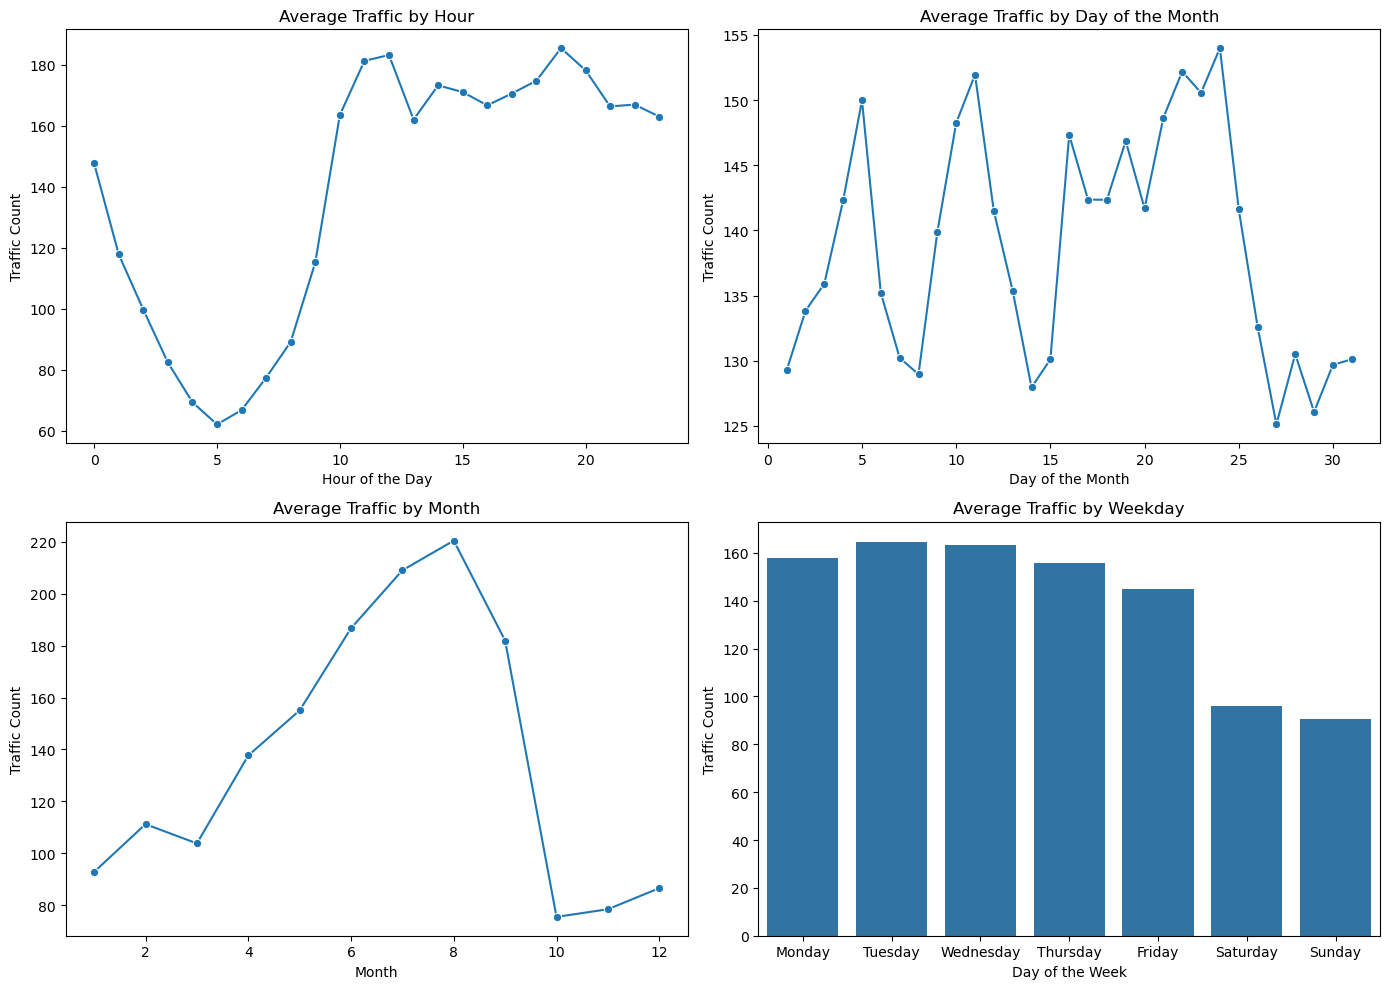

(Hour
 0     147.695538
 1     117.868766
 2      99.753281
 3      82.422572
 4      69.375328
 5      62.102362
 6      66.776903
 7      77.443570
 8      89.181102
 9     115.241470
 10    163.572178
 11    181.341207
 12    183.262467
 13    162.081365
 14    173.304462
 15    171.115486
 16    166.748031
 17    170.632546
 18    174.832021
 19    185.514436
 20    178.272966
 21    166.398950
 22    167.002625
 23    163.055118
 Name: Count, dtype: float64,
 Day
 1     129.256667
 2     133.830000
 3     135.906667
 4     142.310000
 5     149.976667
 6     135.200000
 7     130.216667
 8     128.960000
 9     139.873333
 10    148.243333
 11    151.950000
 12    141.470000
 13    135.356667
 14    127.956667
 15    130.103333
 16    147.320000
 17    142.363333
 18    142.346667
 19    146.853333
 20    141.690000
 21    148.650000
 22    152.186667
 23    150.556667
 24    153.983333
 25    141.618590
 26    132.620000
 27    125.113333
 28    130.513333
 29    126.065217
 30  

In [46]:
import seaborn as sns

# Extract date components
train_df["Datetime"] = pd.to_datetime(train_df["Datetime"])
train_df["Hour"] = train_df["Datetime"].dt.hour
train_df["Day"] = train_df["Datetime"].dt.day
train_df["Month"] = train_df["Datetime"].dt.month
train_df["Weekday"] = train_df["Datetime"].dt.weekday
train_df["Is_Weekend"] = train_df["Weekday"] >= 5

# Aggregate traffic by different time periods
hourly_trend = train_df.groupby("Hour")["Count"].mean()
daily_trend = train_df.groupby("Day")["Count"].mean()
monthly_trend = train_df.groupby("Month")["Count"].mean()
weekday_trend = train_df.groupby("Weekday")["Count"].mean()

# Plot seasonality trends
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.lineplot(ax=axes[0, 0], x=hourly_trend.index, y=hourly_trend.values, marker="o")
axes[0, 0].set_title("Average Traffic by Hour")
axes[0, 0].set_xlabel("Hour of the Day")
axes[0, 0].set_ylabel("Traffic Count")

sns.lineplot(ax=axes[0, 1], x=daily_trend.index, y=daily_trend.values, marker="o")
axes[0, 1].set_title("Average Traffic by Day of the Month")
axes[0, 1].set_xlabel("Day of the Month")
axes[0, 1].set_ylabel("Traffic Count")

sns.lineplot(ax=axes[1, 0], x=monthly_trend.index, y=monthly_trend.values, marker="o")
axes[1, 0].set_title("Average Traffic by Month")
axes[1, 0].set_xlabel("Month")
axes[1, 0].set_ylabel("Traffic Count")

sns.barplot(ax=axes[1, 1], x=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
            y=weekday_trend.values)
axes[1, 1].set_title("Average Traffic by Weekday")
axes[1, 1].set_xlabel("Day of the Week")
axes[1, 1].set_ylabel("Traffic Count")

plt.tight_layout()
plt.show()

# Display insights
hourly_trend, daily_trend, monthly_trend, weekday_trend


In [ ]:
# 1️⃣ Identify Growth Levers Based on Analysis
# 🔹 Peak & Off-Peak Demand:

# If ridership is high during specific hours/days/months, leverage this by offering premium pricing or loyalty discounts.
# If ridership is low during off-peak times, introduce promotions or bundled ticketing to encourage travel.
# 🔹 Weekend vs. Weekday Trends:

# If weekends show higher demand → Focus on leisure & tourism partnerships.
# If weekdays have steady demand → Target commuters & businesses with subscription models.
# 🔹 Seasonal Effects:

# Identify if certain months are low → Introduce seasonal campaigns or special services.

# 1️⃣ Identify Growth Levers Based on Analysis
# 🔹 Peak & Off-Peak Demand:

# If ridership is high during specific hours/days/months, leverage this by offering premium pricing or loyalty discounts.
# If ridership is low during off-peak times, introduce promotions or bundled ticketing to encourage travel.
# 🔹 Weekend vs. Weekday Trends:

# If weekends show higher demand → Focus on leisure & tourism partnerships.
# If weekdays have steady demand → Target commuters & businesses with subscription models.
# 🔹 Seasonal Effects:

# Identify if certain months are low → Introduce seasonal campaigns or special services.



In [ ]:
# 🌟 Key Lessons for JetRail's Growth Strategy
# 1.Adopt AI-powered demand forecasting (FlixBus-style dynamic pricing).
# 2.Leverage partnerships for route expansion & multi-modal connectivity (Citymapper approach).
# 3.Consider additional revenue streams (Go-Jek’s super app model).
# 4.Target high-speed logistics & niche transport markets (Zipline’s approach)

# Example
# Citymapper Pass – Smart Urban Travel Subscription
# 🚀 Strategy:

# Citymapper started as a navigation app but later introduced Citymapper Pass, an all-in-one urban mobility subscription.
# Partnered with public transit, ride-sharing, and e-scooter services to create a seamless multi-modal transport experience.
# Used real-time data to optimize routes and pricing.
# 📈 Key Takeaways for JetRail:
# ✅ Consider a subscription model for daily riders.
# ✅ Integrate with other mobility services (buses, cabs) for last-mile connectivity